# Crossentropy method

This notebook will teach you to solve reinforcement learning problems with crossentropy method. We'll follow-up by scaling everything up and using neural network policy.

In [2]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package libfontenc1:amd64.
(Reading database ... 124926 files and directories currently installed.)
Preparing to unpack .../0-libfontenc1_1%3a1.1.4-1build3_amd64.deb ...
Unpacking libfontenc1:amd64 (1:1.1.4-1build3) ...
Selecting previously unselected package libxfont2:amd64.
Preparing to unpack .../1-libxfont2_1%3a2.0.5-1build1_amd64.deb ...
Unpacking libxfont2:amd64 (1:2.0.5-1build1) ...
Selecting previously unselected package libxkbfile1:amd64.
Preparing to unpack .../2-libxkbfile1_1%3a1.1.0-1build3_amd64.deb ...
Unpacking libxkbfile1:amd64 (1:1.1.0-1build3) ...
Selecting previously unselected package x11-xkb-utils.
Preparing to unpack .../3-x11-xkb-utils_7.7+5build4_amd64.deb ...
Unpacking x11-xkb-utils (7.7+5build4) ...
Selecting previously unselected package xfon

In [3]:
!pip install gymnasium[toy_text]

(314, {'prob': 1.0, 'action_mask': array([1, 1, 0, 0, 0, 0], dtype=int8)})


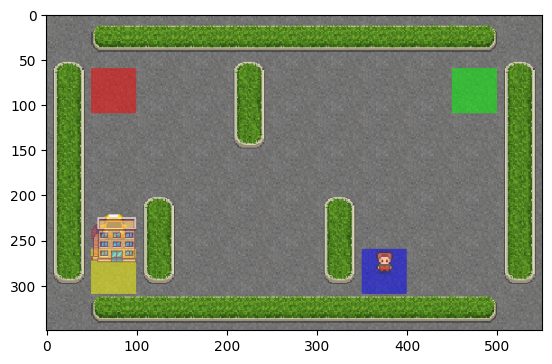

In [4]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

env = gym.make("Taxi-v3", render_mode="rgb_array")
print(env.reset(seed=0))
plt.imshow(env.render())


In [5]:
n_states = env.observation_space.n
n_actions = env.action_space.n

print(f"n_states={n_states}, n_actions={n_actions}")


n_states=500, n_actions=6


# Create stochastic policy

This time our policy should be a probability distribution.

```policy[s,a] = P(take action a | in state s)```

Since we still use integer state and action representations, you can use a 2-dimensional array to represent the policy.

Please initialize the policy __uniformly__, that is, probabililities of all actions should be equal.

In [6]:
def initialize_policy(n_states, n_actions):
    policy = np.ones((n_states, n_actions), dtype=np.float32)/n_actions

    return policy


policy = initialize_policy(n_states, n_actions)
print(policy[0])


[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]


In [7]:
assert type(policy) in (np.ndarray, np.matrix)
assert np.allclose(policy, 1.0 / n_actions)
assert np.allclose(np.sum(policy, axis=1), 1)


# Play the game

Just like before, but we also record all states and actions we took.

In [175]:
def generate_session(env, policy, t_max=10**4, s=None, dropout=0.0, a=None, return_only_reward=False):
    """
    Play game until end or for t_max ticks.
    :param policy: an array of shape [n_states,n_actions] with action probabilities
    :returns: list of states, list of actions and sum of rewards
    """
    if not return_only_reward:
        states, actions = [], []
    total_reward = 0.0

    if not s:
        # print(env.reset())
        s, _ = env.reset()

    if a:
        if not return_only_reward:
            states.append(s)
            actions.append(a)
        new_s, r, terminated, truncated, _ = env.step(a)
        total_reward += r
        s = new_s
    # env.unwrapped.s = s
    # a = np.random.choice(range(n_actions))
    # states.append(s)
    # actions.append(a)



    for t in range(t_max):
        # Hint: you can use np.random.choice for sampling action
        # https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html

        if np.random.uniform(0, 1) < dropout:
            a = np.random.choice(range(n_actions))
        else:
            a = np.random.choice(range(n_actions), p=policy[s])

        # print(env.step(a))
        new_s, r, terminated, truncated, _ = env.step(a)

        # Record information we just got from the environment.
        if not return_only_reward:
            states.append(s)
            actions.append(a)
        total_reward += r

        s = new_s
        if terminated:
            break
    if return_only_reward:
        return total_reward
    else:
        return states, actions, total_reward


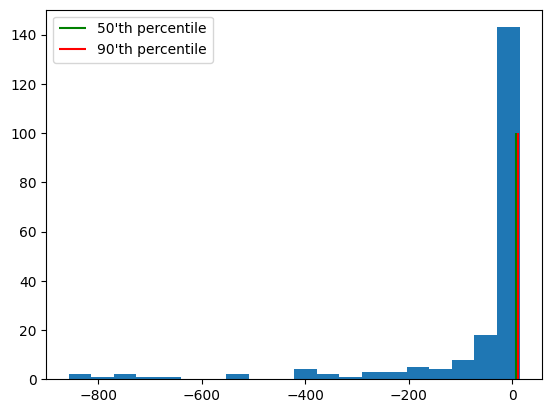

In [65]:
# let's see the initial reward distribution
import matplotlib.pyplot as plt
%matplotlib inline

sample_rewards = [generate_session(env, policy, t_max=1000)[-1] for _ in range(200)]

plt.hist(sample_rewards, bins=20)
plt.vlines([np.percentile(sample_rewards, 50)], [0], [100], label="50'th percentile", color='green')
plt.vlines([np.percentile(sample_rewards, 90)], [0], [100], label="90'th percentile", color='red')
plt.legend()

### Crossentropy method steps

In [10]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """

    reward_threshold = np.percentile(rewards_batch, percentile)

    elite_states = []
    elite_actions = []
    for states, actions, reward in zip(states_batch, actions_batch, rewards_batch):
        if reward >= reward_threshold:
            elite_states.extend(states)
            elite_actions.extend(actions)

    return elite_states, elite_actions


In [11]:
states_batch = [
    [1, 2, 3],     # game1
    [4, 2, 0, 2],  # game2
    [3, 1],        # game3
]

actions_batch = [
    [0, 2, 4],     # game1
    [3, 2, 0, 1],  # game2
    [3, 3],        # game3
]
rewards_batch = [
    3,  # game1
    4,  # game2
    5,  # game3
]

test_result_0 = select_elites(states_batch, actions_batch, rewards_batch, percentile=0)
test_result_30 = select_elites(
    states_batch, actions_batch, rewards_batch, percentile=30
)
test_result_90 = select_elites(
    states_batch, actions_batch, rewards_batch, percentile=90
)
test_result_100 = select_elites(
    states_batch, actions_batch, rewards_batch, percentile=100
)

assert np.all(test_result_0[0] == [1, 2, 3, 4, 2, 0, 2, 3, 1]) and np.all(
    test_result_0[1] == [0, 2, 4, 3, 2, 0, 1, 3, 3]
), "For percentile 0 you should return all states and actions in chronological order"
assert np.all(test_result_30[0] == [4, 2, 0, 2, 3, 1]) and np.all(
    test_result_30[1] == [3, 2, 0, 1, 3, 3]
), "For percentile 30 you should only select states/actions from two first"
assert np.all(test_result_90[0] == [3, 1]) and np.all(
    test_result_90[1] == [3, 3]
), "For percentile 90 you should only select states/actions from one game"
assert np.all(test_result_100[0] == [3, 1]) and np.all(
    test_result_100[1] == [3, 3]
), "Please make sure you use >=, not >. Also double-check how you compute percentile."

print("Ok!")


Ok!


In [12]:
def get_new_policy(elite_states, elite_actions):
    """
    Given a list of elite states/actions from select_elites,
    return a new policy where each action probability is proportional to

        policy[s_i,a_i] ~ #[occurrences of s_i and a_i in elite states/actions]

    Don't forget to normalize the policy to get valid probabilities and handle the 0/0 case.
    For states that you never visited, use a uniform distribution (1/n_actions for all states).

    :param elite_states: 1D list of states from elite sessions
    :param elite_actions: 1D list of actions from elite sessions

    """

    new_policy = np.zeros([n_states, n_actions])

    for state, action in zip(elite_states, elite_actions):
        new_policy[state, action] += 1

    for state in range(n_states):
        total_occurrences = np.sum(new_policy[state])

        if total_occurrences > 0:
            new_policy[state] /= total_occurrences
        else:
            new_policy[state] = np.ones(n_actions) / n_actions

    return new_policy


In [13]:
elite_states = [1, 2, 3, 4, 2, 0, 2, 3, 1]
elite_actions = [0, 2, 4, 3, 2, 0, 1, 3, 3]

new_policy = get_new_policy(elite_states, elite_actions)

assert np.isfinite(
    new_policy
).all(), "Your new policy contains NaNs or +-inf. Make sure you don't divide by zero."
assert np.all(
    new_policy >= 0
), "Your new policy can't have negative action probabilities"
assert np.allclose(
    new_policy.sum(axis=-1), 1
), "Your new policy should be a valid probability distribution over actions"

reference_answer = np.array(
    [
        [1.0, 0.0, 0.0, 0.0, 0.0],
        [0.5, 0.0, 0.0, 0.5, 0.0],
        [0.0, 0.33333333, 0.66666667, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.5, 0.5],
    ]
)
assert np.allclose(new_policy[:4, :5], reference_answer)

print("Ok!")


Ok!


# Training loop
Generate sessions, select N best and fit to those.

In [14]:
from IPython.display import clear_output


def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress.
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label="Mean rewards")
    plt.plot(list(zip(*log))[1], label="Reward thresholds")
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines(
        [np.percentile(rewards_batch, percentile)],
        [0],
        [100],
        label="percentile",
        color="red",
    )
    plt.legend()
    plt.grid()
    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.show()


In [148]:
policy = initialize_policy(n_states, n_actions)
n_sessions = 250  # sample this many sessions
percentile = 50  # discard this percentage of sessions with lowest rewards
learning_rate = 0.5  # how quickly the policy is updated, on a scale from 0 to 1

log = []

for i in range(40):
    %time sessions = [ generate_session(env, policy, t_max=10**3) for _ in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = zip(*sessions)

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

    new_policy = get_new_policy(elite_states, elite_actions)
    policy = learning_rate * new_policy + (1 - learning_rate) * policy

    # display results on chart
    show_progress(rewards_batch, log, percentile)


mean reward = -1.000, threshold=-1.000


KeyboardInterrupt: 

mean reward = -2.093, threshold=6.000


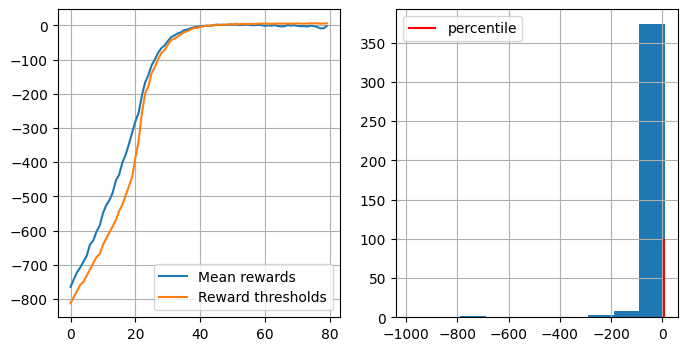

In [80]:
policy = initialize_policy(n_states, n_actions)
n_sessions = 450  # sample this many sessions
percentile = 30  # discard this percentage of sessions with lowest rewards
learning_rate = 0.5  # how quickly the policy is updated, on a scale from 0 to 1

log = []

for i in range(0, 80):
    %time sessions = [ generate_session(env, policy, t_max=10**3) for _ in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = zip(*sessions)

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

    new_policy = get_new_policy(elite_states, elite_actions)
    assert np.allclose(new_policy.sum(axis=1), np.ones(n_states, dtype=np.float32))
    policy = learning_rate * new_policy + (1 - learning_rate) * policy
    assert np.allclose(policy.sum(axis=1), np.ones(n_states, dtype=np.float32))
    # display results on chart
    show_progress(rewards_batch, log, percentile)


mean reward = -33.871, threshold=8.000


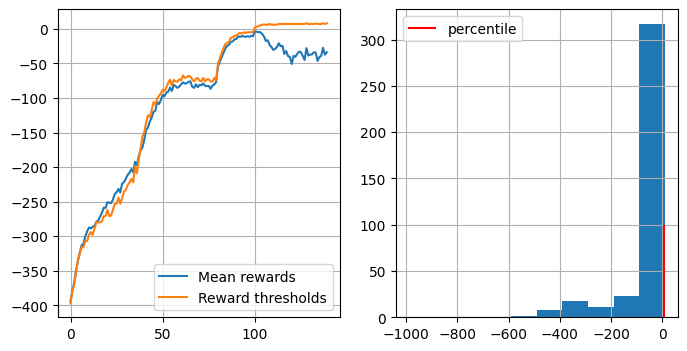

In [61]:
# policy = initialize_policy(n_states, n_actions)
n_sessions = 450  # sample this many sessions
percentile = 50  # discard this percentage of sessions with lowest rewards
learning_rate = 0.2  # how quickly the policy is updated, on a scale from 0 to 1

# log = []

for i in range(120, 140):
    %time sessions = [ generate_session(env, policy, t_max=100, s=None, dropout=0.00) for _ in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = zip(*sessions)
    # print(actions_batch[:4])

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

    new_policy = get_new_policy(elite_states, elite_actions)
    # assert np.allclose(new_policy.sum(axis=1), np.ones(n_states, dtype=np.float32))
    policy = learning_rate * new_policy + (1 - learning_rate) * policy
    # assert np.allclose(policy.sum(axis=1), np.ones(n_states, dtype=np.float32))
    # display results on chart
    show_progress(rewards_batch, log, percentile)


mean reward = -388.612, threshold=-370.000


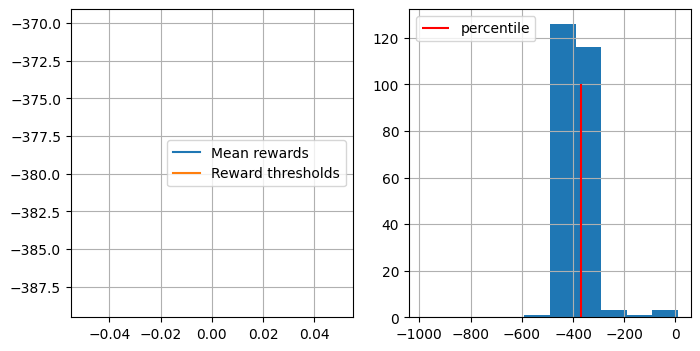

In [77]:
lg = []
from scipy.special import softmax
# new_police = softmax(policy, axis=1)
sessions = [ generate_session(env, new_policy, t_max=100, s=None, dropout=0.00) for _ in range(n_sessions)]
states_batch, actions_batch, rewards_batch = zip(*sessions)
show_progress(rewards_batch, lg, percentile)

mean reward = 7.740, threshold=8.000


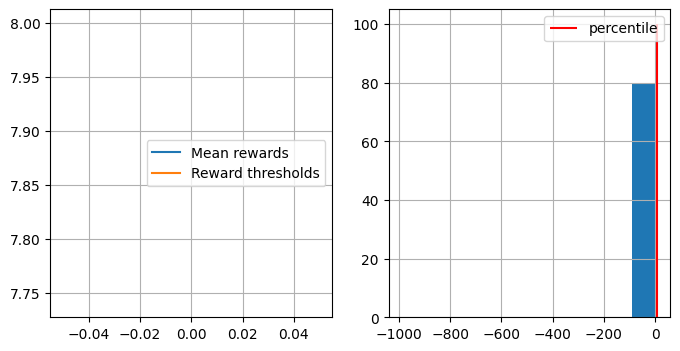

([126, 226, 246, 266, 286, 186, 86, 98, 78, 178, 278, 258, 238, 218, 318, 418], [283, 263, 243, 223, 123, 103, 3, 19, 119, 219, 239, 259, 279, 379, 479], [373, 473, 477, 377, 277, 177, 77, 97], [342, 322, 222, 122, 102, 2, 18, 118, 218, 318, 418], [248, 228, 208, 308, 408, 416, 316, 216, 116, 16], [26, 126, 226, 246, 266, 286, 186, 86, 98, 78, 178, 278, 258, 238, 218, 318, 418], [262, 242, 222, 122, 102, 2, 18, 118, 218, 318, 418], [67, 87, 99, 199, 299, 279, 379, 479], [348, 248, 228, 208, 308, 408, 416, 316, 216, 116, 16], [412, 312, 212, 232, 252, 272, 372, 472, 476, 376, 276, 256, 236, 216, 116, 16], [311, 411, 419, 319, 219, 239, 259, 279, 379, 479], [251, 231, 211, 311, 411, 419, 319, 219, 239, 259, 279, 379, 479], [89, 189, 289, 269, 249, 229, 209, 309, 409, 417, 317, 217, 237, 257, 277, 177, 77, 97], [26, 126, 226, 246, 266, 286, 186, 86, 98, 78, 178, 278, 258, 238, 218, 318, 418], [229, 209, 309, 409, 417, 317, 217, 237, 257, 277, 177, 77, 97], [112, 212, 232, 252, 272, 372, 4

In [166]:
from scipy.special import softmax
env = gym.make("Taxi-v3", render_mode="rgb_array")
# new_policy = softmax(policy*10, axis=1)
# q_table
sessions = [ generate_session(env, table, t_max=100) for _ in range(100)]
states_batch, actions_batch, rewards_batch = zip(*sessions)
logg = []
show_progress(rewards_batch, logg, percentile)

print(states_batch)


In [142]:
print(states_batch[:4])
print(actions_batch[:4])
print(rewards_batch[:4])

([429], [61], [148], [14])
([1], [3], [0], [2])
(-1.0, -1.0, -1.0, -1.0)


In [134]:
ids = q_table.argmax(axis=1)
table = np.zeros_like(q_table)
for i in range(table.shape[0]):
    table[i][ids[i]] = 1.0
table

array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.]])

mean reward = -21.083, threshold=8.000


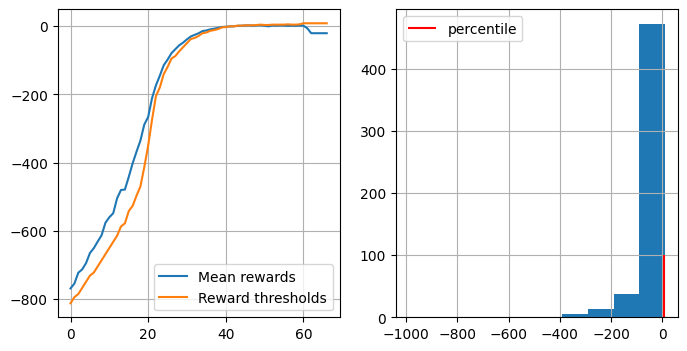

In [ ]:
policy = initialize_policy(n_states, n_actions)
n_sessions = 450  # sample this many sessions
percentile = 30  # discard this percentage of sessions with lowest rewards
learning_rate = 0.5  # how quickly the policy is updated, on a scale from 0 to 1

log = []



for i in range(0, 60):
    %time sessions = [ generate_session(env, policy, t_max=10**3) for _ in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = zip(*sessions)

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

    new_policy = get_new_policy(elite_states, elite_actions)
    policy = learning_rate * new_policy + (1 - learning_rate) * policy

    # display results on chart
    show_progress(rewards_batch, log, percentile)


In [85]:

import copy
from tqdm import tqdm
env = gym.make("Taxi-v3", render_mode="rgb_array")
# policy = initialize_policy(n_states, n_actions)
n_sessions = 250  # sample this many sessions
# percentile = 70 # discard this percentage of sessions with lowest rewards
learning_rate = 0.3  # how quickly the policy is updated, on a scale from 0 to 1

log = []

# for _ in range(500):
#     start, _ = env.reset()

#     for action in range(n_actions):
#         for _ in range(10):
#             sessions = []
#             fixed_env = copy.copy(env)
#             sessions.append(generate_session(fixed_env, policy, t_max=10**3, s=start, a=action))

#     # rewbs = []
logg = []
for _ in range(20):
    for i in tqdm(range(400)):
        start, _ = env.reset()
        states = []
        actions = []
        # sessions = []
        fixed_env = copy.copy(env)
        rewards = []
        for act in range(n_actions):
            reward = 0.0
            sessions = []
            for _ in range(100):
                sessions.append(generate_session(fixed_env, policy, t_max=100, s=start, a=act, return_only_reward=False))
            states_batch, actions_batch, rewards_batch = zip(*sessions)
            print(states_batch[:4])
            print(actions_batch[:4])
            reward = sum(rewards_batch)
            rewards.append(reward)
            break
        break
        opt_action = rewards.index(max(rewards))
        states.append(start)
        actions.append(opt_action)
        new_policy = get_new_policy(states, actions)
        policy = learning_rate * new_policy + (1 - learning_rate) * policy
        # show_progress(rewards_batch, log, percentile)
    break
    sessions = [ generate_session(env, policy, t_max=100) for _ in range(n_sessions)]
    states_batch, actions_batch, rewards_batch = zip(*sessions)
    show_progress(rewards_batch, logg, percentile)


  0%|          | 0/400 [00:00<?, ?it/s]

([128, 108, 208, 208, 308, 408, 416, 316, 216, 116, 16], [128, 0, 16], [128, 0, 100, 200, 100, 100, 100, 120, 120, 100, 100, 120, 120, 20, 0, 0, 0, 0, 0, 0, 16], [128, 0, 100, 120, 100, 100, 100, 100, 0, 16])
([3, 0, 3, 0, 0, 4, 1, 1, 1, 1, 5], [3, 4, 5], [3, 0, 0, 1, 4, 3, 2, 5, 3, 4, 2, 2, 1, 3, 3, 5, 1, 1, 1, 4, 5], [3, 0, 2, 3, 5, 5, 4, 1, 4, 5])


In [147]:

env = gym.make("Taxi-v3", render_mode="rgb_array")

s, _ = env.reset()
copy_env= copy.copy(env)
print(env.step(1))
print(copy_env.step(1))

TypeError: cannot unpack non-iterable int object

In [176]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo

env1 = gym.make("Taxi-v3", render_mode="rgb_array")  # Ensure correct render mode
env1 = RecordVideo(env1, video_folder="./videos4", episode_trigger=lambda x: True)

# Reset environment before use
# env1.reset()

# Generate sessions
sessions = [generate_session(env1, table, 200) for _ in range(10)]

env1.close()  # Ensure proper closing


/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/videos4 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [169]:
table

array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.]])

In [119]:
import gym
import numpy
import random
from os import system, name
from time import sleep

env = gym.make("Taxi-v3").env

# Matrix filled with zeros.
# The matrix will be 500x6 as there are 500 states and 6 actions.
q_table = numpy.zeros([env.observation_space.n, env.action_space.n])

training_episodes = 20000 # Amount of times to run environment while training.
display_episodes = 10 # Amount of times to run environment after training.

# Hyperparameters
alpha = 0.1 # Learning Rate
gamma = 0.6 # Discount Rate
epsilon = 0.1 # Chance of selecting a random action instead of maximising reward.

# For plotting metrics
all_epochs = []
all_penalties = []


for i in range(training_episodes):
    state = env.reset()
    done = False
    penalties, reward, = 0, 0

    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()
        else:
            action = numpy.argmax(q_table[state])

        next_state, reward, done, info = env.step(action)

        old_value = q_table[state, action]
        next_max = numpy.max(q_table[next_state])

        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        if reward == -10:
            penalties += 1

        state = next_state

    if i % 100 == 0:
        print(f"Episode: {i}")

print("Training finished.\n")

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode: 0
Episode: 100
Episode: 200
Episode: 300
Episode: 400
Episode: 500
Episode: 600
Episode: 700
Episode: 800
Episode: 900
Episode: 1000
Episode: 1100
Episode: 1200
Episode: 1300
Episode: 1400
Episode: 1500
Episode: 1600
Episode: 1700
Episode: 1800
Episode: 1900
Episode: 2000
Episode: 2100
Episode: 2200
Episode: 2300
Episode: 2400
Episode: 2500
Episode: 2600
Episode: 2700
Episode: 2800
Episode: 2900
Episode: 3000
Episode: 3100
Episode: 3200
Episode: 3300
Episode: 3400
Episode: 3500
Episode: 3600
Episode: 3700
Episode: 3800
Episode: 3900
Episode: 4000
Episode: 4100
Episode: 4200
Episode: 4300
Episode: 4400
Episode: 4500
Episode: 4600
Episode: 4700
Episode: 4800
Episode: 4900
Episode: 5000
Episode: 5100
Episode: 5200
Episode: 5300
Episode: 5400
Episode: 5500
Episode: 5600
Episode: 5700
Episode: 5800
Episode: 5900
Episode: 6000
Episode: 6100
Episode: 6200
Episode: 6300
Episode: 6400
Episode: 6500
Episode: 6600
Episode: 6700
Episode: 6800
Episode: 6900
Episode: 7000
Episode: 7100
Epis

### Reflecting on results

You may have noticed that the taxi problem quickly converges from less than -1000 to a near-optimal score and then descends back into -50/-100. This is in part because the environment has some innate randomness. Namely, the starting points of passenger/driver change from episode to episode.

In case CEM failed to learn how to win from one distinct starting point, it will simply discard it because no sessions from that starting point will make it into the "elites".

To mitigate that problem, you can either reduce the threshold for elite sessions (duct tape way) or change the way you evaluate strategy (theoretically correct way). For each starting state, you can sample an action randomly, and then evaluate this action by running _several_ games starting from it and averaging the total reward. Choosing elite sessions with this kind of sampling (where each session's reward is counted as the average of the rewards of all sessions with the same starting state and action) should improve the performance of your policy.


### You're not done yet!

Go to [`./deep_crossentropy_method.ipynb`](./deep_crossentropy_method.ipynb) for a more serious task